In [1]:
!pip install mplfinance -q
!pip install ta -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls -al /content/drive/MyDrive/IS_Safem0de

total 1565
drwx------ 2 root root    4096 Nov  3 04:15 colab
drwx------ 2 root root    4096 Nov  3 03:28 data
-rw------- 1 root root   74953 Nov  4 23:54 dqn_fx.pt
-rw------- 1 root root   76397 Nov  5 01:20 dqn_fx_v2.pt
-rw------- 1 root root 1433206 Oct 16 03:59 EURUSD_H4.csv
drwx------ 2 root root    4096 Nov  3 02:47 paper
drwx------ 2 root root    4096 Nov  3 02:48 prelim_midterm


In [4]:
data_path = '/content/drive/MyDrive/IS_Safem0de/EURUSD_H4.csv'
import pandas as pd

df = pd.read_csv(data_path)
df.tail()

,2009-10-05 20:00,1.46469,1.46609,1.46436,1.46558,2247
25842,2025-10-15 08:00,1.16355,1.16453,1.16195,1.16199,16243
25843,2025-10-15 12:00,1.16201,1.16472,1.16103,1.16369,25939
25844,2025-10-15 16:00,1.16371,1.16448,1.16269,1.16441,14745
25845,2025-10-15 20:00,1.16442,1.16519,1.16418,1.16456,5554
25846,2025-10-16 00:00,1.16455,1.16754,1.16425,1.16659,14450


In [5]:
import numpy as np
import pandas as pd

def ensure_datetime_index(df):
    d = df.copy()
    if 'datetime' in d.columns:
        d['datetime'] = pd.to_datetime(d['datetime'], errors='coerce')
        d = d.set_index('datetime')
    if not isinstance(d.index, pd.DatetimeIndex):
        d.index = pd.to_datetime(d.index, errors='coerce')
    d = d[~d.index.isna()].sort_index()
    d = d[~d.index.duplicated(keep='first')]
    return d

In [6]:
# ตรวจชื่อคอลัมน์
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

# แปลง datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# ตั้ง index เป็นเวลา (สะดวกกับการ plot)
df.set_index('datetime', inplace=True)

# 1) ทำให้ index เป็น Datetime ที่เรียงและไม่ซ้ำ
df = ensure_datetime_index(df)

# 2) TDD checks เบื้องต้น
assert isinstance(df.index, pd.DatetimeIndex)
assert df.index.is_monotonic_increasing
assert not df.index.has_duplicates
assert {'open','high','low','close'}.issubset(df.columns)

print(df.index.min(), '→', df.index.max(), 'rows=', len(df))
display(df.head(3)); display(df.tail(3))

2009-10-06 00:00:00 → 2025-10-16 00:00:00 rows= 25847


,open,high,low,close,volume
datetime,,,,,
2009-10-06 00:00:00,1.46563,1.47178,1.46541,1.47035,10300
2009-10-06 04:00:00,1.47051,1.47486,1.46951,1.47169,12566
2009-10-06 08:00:00,1.47176,1.47458,1.47068,1.47264,18816


,open,high,low,close,volume
datetime,,,,,
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554
2025-10-16 00:00:00,1.16455,1.16754,1.16425,1.16659,14450


In [7]:
def compute_atr(df: pd.DataFrame, window: int = 14) -> pd.Series:
    req = {'high','low','close'}
    if not req.issubset(df.columns):
        raise ValueError(f"ต้องมีคอลัมน์ {req} ใน df")
    high, low, close = df['high'], df['low'], df['close']
    prev_close = close.shift(1)
    tr = pd.concat([(high-low), (high-prev_close).abs(), (low-prev_close).abs()], axis=1).max(axis=1)
    return tr.rolling(window, min_periods=window).mean().rename('atr')

def triple_barrier_labels(df: pd.DataFrame, k_atr=2.0, max_horizon=24, atr_window=14) -> pd.Series:
    req = {'high','low','close'}
    if not req.issubset(df.columns):
        raise ValueError(f"ต้องมีคอลัมน์ {req} ใน df")
    atr = df['atr'] if 'atr' in df.columns else compute_atr(df, atr_window)
    close, high, low = df['close'], df['high'], df['low']
    tp = close + k_atr*atr
    sl = close - k_atr*atr
    labels = np.zeros(len(df), dtype=np.int8)

    for i in range(len(df)-1):
        end_i = min(i+max_horizon, len(df)-1)
        win_high = high.iloc[i+1:end_i+1]
        win_low  = low.iloc[i+1:end_i+1]
        hit_tp = (win_high >= tp.iloc[i])
        hit_sl = (win_low  <= sl.iloc[i])
        first_tp = hit_tp.idxmax() if hit_tp.any() else None
        first_sl = hit_sl.idxmax() if hit_sl.any() else None
        if first_tp is not None and first_sl is not None:
            labels[i] = 1 if first_tp <= first_sl else -1
        elif first_tp is not None:
            labels[i] = 1
        elif first_sl is not None:
            labels[i] = -1
        else:
            labels[i] = 0
    return pd.Series(labels, index=df.index, name='label_tb')

def forward_return_labels(df: pd.DataFrame, horizon=24, thr=0.002) -> pd.Series:
    if 'close' not in df.columns:
        raise ValueError("ต้องมีคอลัมน์ 'close'")
    fwd = df['close'].shift(-horizon)/df['close'] - 1.0
    y = pd.Series(0, index=df.index, name='label_fwd')
    y[fwd >  thr] =  1
    y[fwd < -thr] = -1
    return y


In [32]:
def compute_zigzag(df: pd.DataFrame, pct: float = 0.005, atr=None, atr_mult=None):
    """
    ZigZag แบบ 'online' ใช้ได้ทั้งแบบ pct หรือ ATR
    Return: df[['zz_pivot', 'zz_pivot_price', 'zz_swing_dir']]
    """
    close = df['close']
    pivots = np.zeros(len(close), dtype=np.int8)
    pivot_price = np.full(len(close), np.nan)
    direction = np.zeros(len(close), dtype=np.int8)

    last_pivot_idx = 0
    last_pivot_price = close.iloc[0]
    trend = 0
    extreme_price = last_pivot_price

    def crossed(from_price, to_price, ref_idx):
        if atr is not None and atr_mult is not None:
            thr = atr.iloc[ref_idx] * atr_mult
            return abs(to_price - from_price) >= thr
        else:
            return abs(to_price / from_price - 1.0) >= pct

    for i in range(1, len(close)):
        p = close.iloc[i]
        if trend == 0:
            if crossed(last_pivot_price, p, i):
                trend = 1 if p > last_pivot_price else -1
                extreme_price = p
        elif trend == 1:
            if p > extreme_price:
                extreme_price = p
            elif crossed(extreme_price, p, i):
                pivots[i - 1] = 1
                pivot_price[i - 1] = extreme_price
                direction[i - 1] = 1
                last_pivot_idx = i - 1
                last_pivot_price = extreme_price
                trend = -1
                extreme_price = p
        else:  # trend == -1
            if p < extreme_price:
                extreme_price = p
            elif crossed(extreme_price, p, i):
                pivots[i - 1] = -1
                pivot_price[i - 1] = extreme_price
                direction[i - 1] = -1
                last_pivot_idx = i - 1
                last_pivot_price = extreme_price
                trend = 1
                extreme_price = p

    return pd.DataFrame({
        'zz_pivot': pivots,
        'zz_pivot_price': pivot_price,
        'zz_swing_dir': direction
    }, index=df.index)


In [34]:
# 1) ATR เป็นคอลัมน์
df['atr'] = compute_atr(df)

# 2) Triple-Barrier labels เป็นคอลัมน์
df['label_tb'] = triple_barrier_labels(df, k_atr=2.0, max_horizon=24, atr_window=14)

# 3) Forward-return labels เป็นคอลัมน์
df['label_fwd'] = forward_return_labels(df, horizon=24, thr=0.002)

# 4) ZigZag (แบบใหม่)
zz = compute_zigzag(df, pct=0.004, atr=df['atr'])
df = df.join(zz)

df.tail(10)

,open,high,low,close,volume,atr,label_tb,label_fwd,zigzag,zz_pivot,zz_pivot_price,zz_swing_dir
datetime,,,,,,,,,,,,
2025-10-14 12:00:00,1.15520,1.16081,1.15479,1.16071,29535,0.003237,1,0,0,0,NaN,0
2025-10-14 16:00:00,1.16073,1.16148,1.16011,1.16053,16173,0.003125,1,0,0,0,NaN,0
2025-10-14 20:00:00,1.16055,1.16097,1.15997,1.16032,4331,0.002686,1,0,0,0,NaN,0
2025-10-15 00:00:00,1.16030,1.16258,1.16017,1.16221,13667,0.002654,1,0,0,0,NaN,0
2025-10-15 04:00:00,1.16223,1.16445,1.16168,1.16356,15760,0.002675,0,0,0,0,NaN,0
2025-10-15 08:00:00,1.16355,1.16453,1.16195,1.16199,16243,0.002663,1,0,0,0,NaN,0
2025-10-15 12:00:00,1.16201,1.16472,1.16103,1.16369,25939,0.002695,0,0,0,0,NaN,0
2025-10-15 16:00:00,1.16371,1.16448,1.16269,1.16441,14745,0.002541,0,0,0,0,NaN,0
2025-10-15 20:00:00,1.16442,1.16519,1.16418,1.16456,5554,0.002470,0,0,0,0,NaN,0


In [37]:
import numpy as np
import pandas as pd
import mplfinance as mpf

def plot_candle_with_labels(
    df: pd.DataFrame,
    label_col: str = 'label_tb',
    offset_atr: float = 0.2,
    show_zigzag: bool = True,
    title: str = None
):
    req_cols = {'open', 'high', 'low', 'close', 'volume'}
    if not req_cols.issubset(df.columns):
        raise ValueError(f"df ต้องมีคอลัมน์ {req_cols}")

    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    if label_col not in df.columns:
        raise ValueError(f"ไม่พบคอลัมน์ '{label_col}'")

    # ATR สำหรับ marker offset
    if 'atr' not in df.columns:
        df['atr'] = compute_atr(df)
    atr = df['atr'].bfill().ffill()

    long_mask = df[label_col] == 1
    short_mask = df[label_col] == -1

    long_y = df['low'] - offset_atr * atr
    short_y = df['high'] + offset_atr * atr
    long_y[~long_mask] = np.nan
    short_y[~short_mask] = np.nan

    mc = mpf.make_marketcolors(up='tab:green', down='tab:red', edge='inherit', wick='gray', volume='tab:blue')
    style = mpf.make_mpf_style(marketcolors=mc, gridcolor='lightgray', facecolor='white')

    apds = [
        mpf.make_addplot(long_y, type='scatter', marker='^', color='tab:green', markersize=80),
        mpf.make_addplot(short_y, type='scatter', marker='v', color='tab:red', markersize=80),
    ]

    # --- ZigZag (optional) ---
    if show_zigzag and 'zz_pivot' in df.columns:
        zz_up = df['zz_pivot'] == 1
        zz_dn = df['zz_pivot'] == -1

        zz_up_y = df.loc[zz_up, 'zz_pivot_price'].reindex(df.index)
        zz_dn_y = df.loc[zz_dn, 'zz_pivot_price'].reindex(df.index)

        pivots = df.loc[df['zz_pivot'] != 0, ['zz_pivot_price']]
        zz_line = pd.Series(np.nan, index=df.index)
        zz_line.loc[pivots.index] = pivots['zz_pivot_price']
        zz_line = zz_line.interpolate()

        apds += [
            mpf.make_addplot(zz_dn_y, type='scatter', marker='o', color='tab:blue', markersize=40),
            mpf.make_addplot(zz_up_y, type='scatter', marker='o', color='orange', markersize=40),
            mpf.make_addplot(zz_line, color='navy', width=2.0),
        ]


    mpf.plot(
        df,
        type='candle',
        addplot=apds,
        volume=True,
        style=style,
        panel_ratios=(3, 1),
        title=title or f"Candlestick + Labels ({label_col})",
        datetime_format='%Y-%m-%d %H:%M',
        figratio=(12, 8),
        figscale=1.1
    )

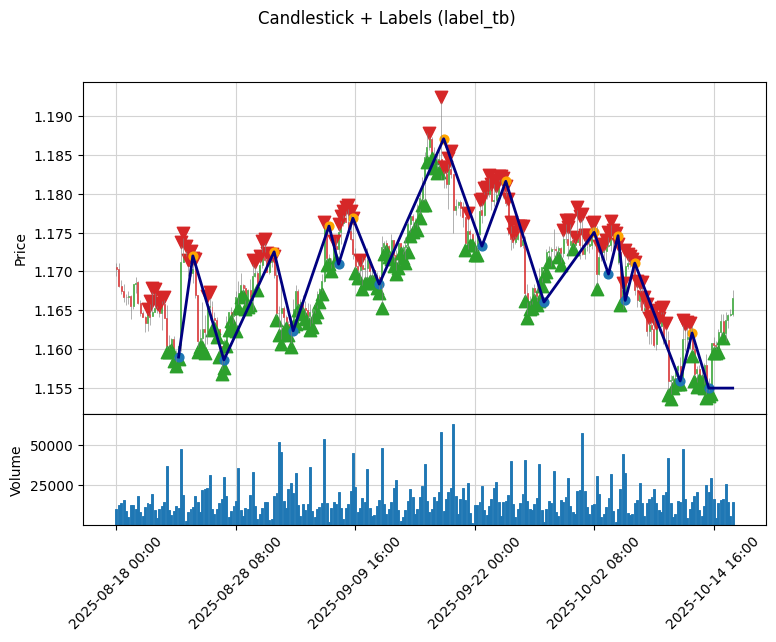

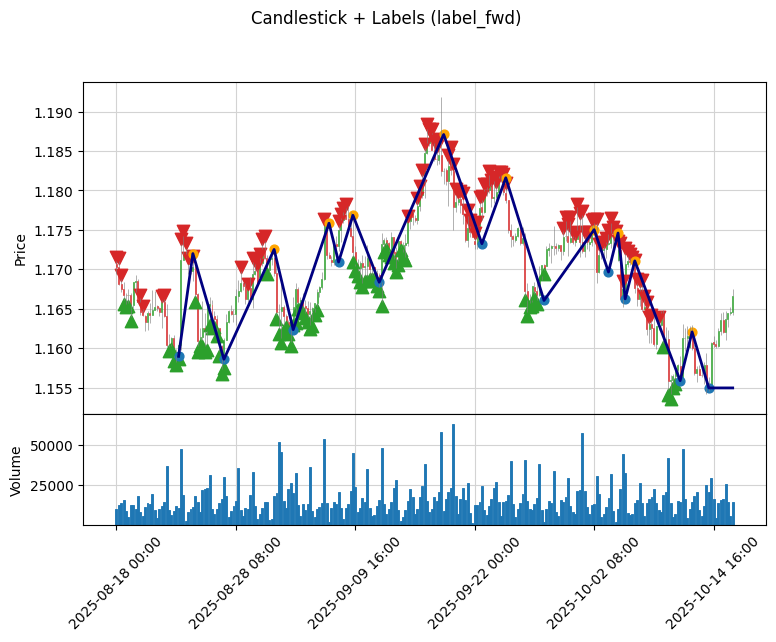

In [38]:
# --- เตรียมข้อมูลก่อน plot ---
df = df.copy()
df.index = pd.to_datetime(df.index)
df = df[df.index.dayofweek < 5]          # ① ตัดเสาร์-อาทิตย์
df = df[df.index >= df.index.max() - pd.Timedelta(days=60)]  # ② เอา 60 วันล่าสุด
df = df.sort_index()                     # ③ เรียงลำดับเวลา

# --- Plot ---
plot_candle_with_labels(df, label_col='label_tb', show_zigzag=True)
plot_candle_with_labels(df, label_col='label_fwd', show_zigzag=True)



In [43]:
import numpy as np
import pandas as pd

def _nearest_distance(mask: pd.Series) -> np.ndarray:
    """ระยะ (เป็นจำนวนแท่ง) ไปยัง pivot ที่ใกล้สุดของ mask=True"""
    n = len(mask)
    idx = np.arange(n, dtype=float)
    pos = np.where(mask.to_numpy(), idx, np.nan)
    last = pd.Series(pos).ffill().to_numpy()
    nxt  = pd.Series(pos).bfill().to_numpy()
    d_last = np.where(np.isnan(last), np.inf, idx - last)
    d_next = np.where(np.isnan(nxt),  np.inf, nxt - idx)
    return np.minimum(d_last, d_next).astype(int)

def _nearest_index(mask: pd.Series) -> np.ndarray:
    """คืน index ของ pivot ที่ใกล้สุด (แบบตำแหน่ง 0..n-1), ถ้าไม่มีให้ -1"""
    n = len(mask)
    idx = np.arange(n, dtype=float)
    pos = np.where(mask.to_numpy(), idx, np.nan)
    last = pd.Series(pos).ffill().to_numpy()
    nxt  = pd.Series(pos).bfill().to_numpy()
    d_last = np.where(np.isnan(last), np.inf, np.abs(idx - last))
    d_next = np.where(np.isnan(nxt),  np.inf, np.abs(nxt - idx))
    choose_next = d_next < d_last
    nearest = np.where(choose_next, nxt, last)
    return np.where(np.isfinite(nearest), nearest, -1).astype(int)

def filter_labels_near_pivots(
    df: pd.DataFrame,
    label_col: str = 'label_tb',
    pivot_col: str = 'zz_pivot',
    pivot_price_col: str = 'zz_pivot_price',
    window: int = 3,
    atr_col: str = 'atr',
    atr_mult: float | None = None
) -> pd.DataFrame:
    """
    เก็บเฉพาะ label ที่ 'สอดคล้อง' กับ pivot ใกล้ ๆ:
      - long (+1) ต้องอยู่ใกล้ pivot down (-1)
      - short(-1) ต้องอยู่ใกล้ pivot up   (+1)

    window: จำนวนแท่งสูงสุดจาก pivot
    atr_mult: ถ้ากำหนด จะต้อง |close - pivot_price| <= atr_mult * ATR ด้วย
    """
    d = df.copy()

    if pivot_col not in d.columns:
        raise ValueError(f"ไม่พบคอลัมน์ '{pivot_col}' (ต้องรัน zigzag_online ก่อน)")
    if label_col not in d.columns:
        raise ValueError(f"ไม่พบคอลัมน์ '{label_col}'")

    n = len(d)
    idx = np.arange(n)

    # ระยะเป็น "จำนวนแท่ง" ไปยัง pivot แต่ละทิศ
    dist_to_up   = _nearest_distance(d[pivot_col] ==  1)
    dist_to_down = _nearest_distance(d[pivot_col] == -1)

    # index ของ pivot ที่ใกล้สุด (สำหรับเช็คระยะราคา)
    near_up_idx   = _nearest_index(d[pivot_col] ==  1)
    near_down_idx = _nearest_index(d[pivot_col] == -1)

    long_mask  = (d[label_col] ==  1)
    short_mask = (d[label_col] == -1)

    keep_long  = long_mask  & (dist_to_down <= window)
    keep_short = short_mask & (dist_to_up   <= window)

    # เงื่อนไขด้านราคา (ออปชัน)
    if atr_mult is not None and atr_col in d.columns and pivot_price_col in d.columns:
        atr_arr = d[atr_col].to_numpy()
        close_arr = d['close'].to_numpy()
        pivot_price_arr = d[pivot_price_col].to_numpy()

        # long: วัดกับ pivot down ที่ใกล้สุด
        pp_long = np.where(near_down_idx >= 0, pivot_price_arr[near_down_idx], np.nan)
        price_ok_long = np.abs(close_arr - pp_long) <= atr_mult * atr_arr

        # short: วัดกับ pivot up ที่ใกล้สุด
        pp_short = np.where(near_up_idx >= 0, pivot_price_arr[near_up_idx], np.nan)
        price_ok_short = np.abs(close_arr - pp_short) <= atr_mult * atr_arr

        keep_long  &= np.isfinite(pp_long)  & price_ok_long
        keep_short &= np.isfinite(pp_short) & price_ok_short

    out = d.copy()
    out[f'{label_col}_near'] = 0
    out.loc[keep_long,  f'{label_col}_near'] =  1
    out.loc[keep_short, f'{label_col}_near'] = -1
    return out


In [44]:
# กรองให้ทิศตรงคู่ + อยู่ใกล้ pivot ภายใน ±3 แท่ง
df = filter_labels_near_pivots(df, label_col='label_tb',  window=3, atr_mult=None)
df = filter_labels_near_pivots(df, label_col='label_fwd', window=3, atr_mult=None)

# ถ้าอยากให้เข้มงวดขึ้น (ต้องใกล้ราคา pivot ไม่เกิน 0.5*ATR)
# df = filter_labels_near_pivots(df, 'label_tb',  window=3, atr_mult=0.5)
# df = filter_labels_near_pivots(df, 'label_fwd', window=3, atr_mult=0.5)



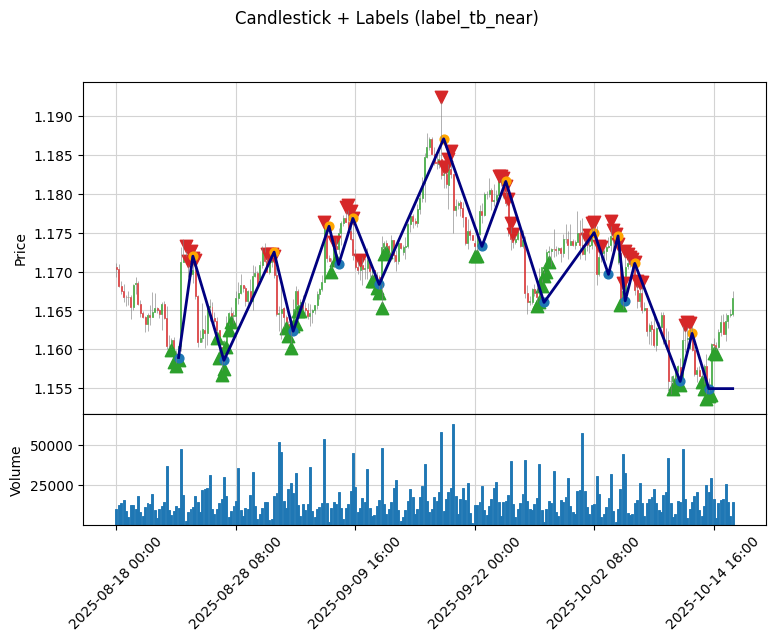

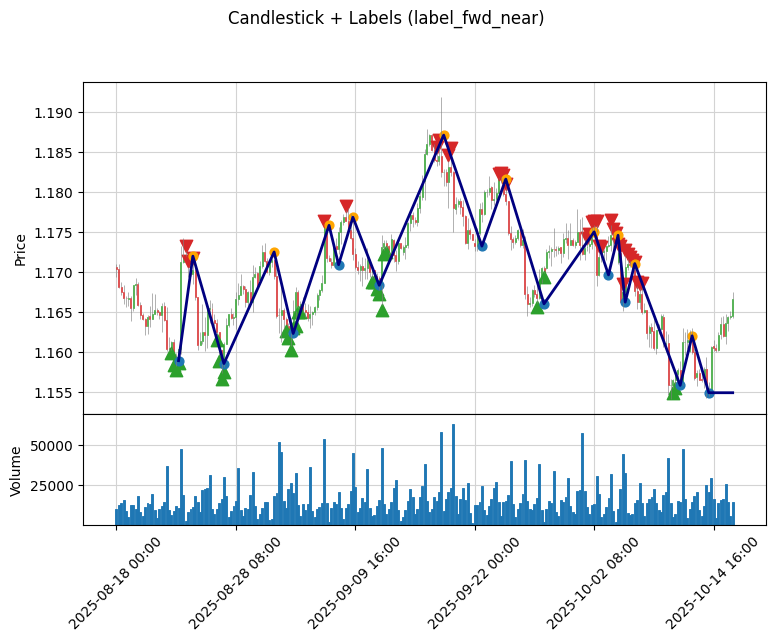

In [45]:
# plot_candle_with_labels(df, label_col='label_tb', show_zigzag=True)
plot_candle_with_labels(df, label_col='label_tb_near', show_zigzag=True)

# plot_candle_with_labels(df, label_col='label_fwd', show_zigzag=True)
plot_candle_with_labels(df, label_col='label_fwd_near', show_zigzag=True)


In [46]:
import numpy as np
import pandas as pd

# ===== helpers =====
def _rolling_sharpe(ret, win=20):
    mu = ret.rolling(win).mean()
    sd = ret.rolling(win).std(ddof=0)
    return (mu / (sd.replace(0, np.nan))).rename(f'sharpe_{win}')

def _zscore(s, win=20):
    m = s.rolling(win).mean()
    sd = s.rolling(win).std(ddof=0)
    return ((s - m) / sd.replace(0, np.nan)).rename(f'{s.name}_z{win}')

def add_donchian(df, window=20):
    out = df.copy()
    out['donchian_upper'] = out['high'].rolling(window).max()
    out['donchian_lower'] = out['low'].rolling(window).min()
    out['donchian_mid']   = (out['donchian_upper'] + out['donchian_lower'])/2
    return out

def add_dow_basic(df):
    out = df.copy()
    highs, lows = out['high'], out['low']
    out['hh'] = (highs > highs.shift(1)) & (highs.shift(1) > highs.shift(2))
    out['ll'] = (lows  < lows .shift(1)) & (lows .shift(1) < lows .shift(2))
    out['hl'] = (lows  > lows .shift(1)) & (highs > highs.shift(1))
    out['lh'] = (highs < highs.shift(1)) & (lows  < lows .shift(1))
    return out

# ===== main feature builder =====
def build_features(df: pd.DataFrame,
                   rsi_win: int = 14,
                   macd_fast: int = 12, macd_slow: int = 26, macd_sig: int = 9,
                   adx_win: int = 14,
                   don_win: int = 20,
                   vol_win: int = 20) -> pd.DataFrame:
    """
    สร้างฟีเจอร์หลายมุมมองสำหรับโมเดล (กัน leakage ด้วยการ shift(1) ตอนท้าย)
    ต้องมีคอลัมน์: open, high, low, close, volume และ DatetimeIndex
    ถ้ามีคอลัมน์ demand/supply zone จะถูกใช้เป็นฟีเจอร์ด้วย
    """
    if not {'open','high','low','close','volume'}.issubset(df.columns):
        raise ValueError("df ต้องมีคอลัมน์ open, high, low, close, volume")

    out = df.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index)

    # --- Core indicators (ใช้ ta แบบไม่พึ่ง external เพื่อพกง่าย) ---
    # ATR & realized volatility
    out['atr'] = compute_atr(out, window=14)
    out['ret1'] = out['close'].pct_change()
    out['rv_' + str(vol_win)] = out['ret1'].rolling(vol_win).std(ddof=0)  # realized vol

    # Moving averages & slope
    out['sma20'] = out['close'].rolling(20).mean()
    out['sma50'] = out['close'].rolling(50).mean()
    out['ema20'] = out['close'].ewm(span=20, adjust=False).mean()
    out['ema50'] = out['close'].ewm(span=50, adjust=False).mean()
    out['ema20_slope'] = out['ema20'].pct_change()  # slope แบบง่าย

    # RSI (แบบง่าย: Wilder approximation)
    delta = out['close'].diff()
    gain = delta.clip(lower=0).rolling(rsi_win).mean()
    loss = (-delta.clip(upper=0)).rolling(rsi_win).mean()
    rs = gain / loss.replace(0, np.nan)
    out['rsi'] = 100 - (100 / (1 + rs))

    # MACD
    ema_fast = out['close'].ewm(span=macd_fast, adjust=False).mean()
    ema_slow = out['close'].ewm(span=macd_slow, adjust=False).mean()
    out['macd'] = ema_fast - ema_slow
    out['macd_signal'] = out['macd'].ewm(span=macd_sig, adjust=False).mean()
    out['macd_hist'] = out['macd'] - out['macd_signal']
    out['macd_turn_up']   = ((out['macd_hist'].shift(1) < 0) & (out['macd_hist'] > 0)).astype(int)
    out['macd_turn_down'] = ((out['macd_hist'].shift(1) > 0) & (out['macd_hist'] < 0)).astype(int)

    # ADX (+DI/-DI แบบย่อ)
    trur = (pd.concat([(out['high']-out['low']),
                       (out['high']-out['close'].shift(1)).abs(),
                       (out['low'] -out['close'].shift(1)).abs()], axis=1).max(axis=1))
    trur_s = trur.rolling(adx_win).sum()
    up_move = out['high'].diff()
    dn_move = -out['low'].diff()
    plus_dm  = np.where((up_move > dn_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((dn_move > up_move) & (dn_move > 0), dn_move, 0.0)
    plus_di  = 100 * pd.Series(plus_dm, index=out.index).rolling(adx_win).sum() / trur_s
    minus_di = 100 * pd.Series(minus_dm, index=out.index).rolling(adx_win).sum() / trur_s
    dx = ( (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0,np.nan) ) * 100
    out['plus_di'] = plus_di
    out['minus_di'] = minus_di
    out['adx'] = dx.rolling(adx_win).mean()

    # Donchian + breakout distance (normalize ด้วย ATR)
    out = add_donchian(out, window=don_win)
    out['dist_up_atr'] = (out['close'] - out['donchian_upper']) / out['atr']
    out['dist_lo_atr'] = (out['close'] - out['donchian_lower']) / out['atr']

    # Candle price action
    body = (out['close'] - out['open']).abs()
    range_ = (out['high'] - out['low']).replace(0, np.nan)
    out['body_pct'] = (body / range_).clip(upper=5)          # guard overflow
    out['upper_wick_pct'] = ((out['high'] - out[['open','close']].max(axis=1)) / range_).clip(lower=0)
    out['lower_wick_pct'] = (((out[['open','close']].min(axis=1)) - out['low']) / range_).clip(lower=0)

    # Volume features
    out['vol_z20'] = _zscore(out['volume'].astype(float), win=20)
    out['vol_of_atr'] = out['volume'] / (out['atr'] * out['close']).replace(0, np.nan)

    # Structure (Dow) → one-hot
    out = add_dow_basic(out)
    out['is_hh'] = out['hh'].astype(int)
    out['is_hl'] = out['hl'].astype(int)
    out['is_lh'] = out['lh'].astype(int)
    out['is_ll'] = out['ll'].astype(int)

    # Regime-ish
    out['sharpe20'] = _rolling_sharpe(out['ret1'], win=20)
    out['trend_20_200'] = (out['sma20'] / out['close'].rolling(200).mean()) - 1

    # Zones (ถ้ามีคอลัมน์โซนอยู่แล้ว จะสร้างระยะทางให้)
    for col in ['demand_zone_low','demand_zone_high','supply_zone_low','supply_zone_high']:
        if col not in out.columns:
            out[col] = np.nan
    out['dist_to_demand'] = (out['close'] - out['demand_zone_high']) / out['atr']
    out['dist_to_supply'] = (out['supply_zone_low'] - out['close']) / out['atr']
    out['in_demand'] = out['close'].between(out['demand_zone_low'], out['demand_zone_high']).astype(int)
    out['in_supply'] = out['close'].between(out['supply_zone_low'], out['supply_zone_high']).astype(int)

    # --- LAG ทุกฟีเจอร์เพื่อกัน leakage ---
    base_cols = ['open','high','low','close','volume']
    feature_cols = [c for c in out.columns if c not in base_cols]
    out[feature_cols] = out[feature_cols].shift(1)

    return out


In [49]:
feat = build_features(df)
print(list(feat.columns))
print(len(feat.columns))

['open', 'high', 'low', 'close', 'volume', 'atr', 'label_tb', 'label_fwd', 'zigzag', 'zz_pivot', 'zz_pivot_price', 'zz_swing_dir', 'label_tb_near', 'label_fwd_near', 'ret1', 'rv_20', 'sma20', 'sma50', 'ema20', 'ema50', 'ema20_slope', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'macd_turn_up', 'macd_turn_down', 'plus_di', 'minus_di', 'adx', 'donchian_upper', 'donchian_lower', 'donchian_mid', 'dist_up_atr', 'dist_lo_atr', 'body_pct', 'upper_wick_pct', 'lower_wick_pct', 'vol_z20', 'vol_of_atr', 'hh', 'll', 'hl', 'lh', 'is_hh', 'is_hl', 'is_lh', 'is_ll', 'sharpe20', 'trend_20_200', 'demand_zone_low', 'demand_zone_high', 'supply_zone_low', 'supply_zone_high', 'dist_to_demand', 'dist_to_supply', 'in_demand', 'in_supply']
58


In [50]:
import numpy as np
import pandas as pd

def remove_corr(X: pd.DataFrame, threshold: float = 0.90):
    Xn = X.select_dtypes(include=[np.number]).copy()
    # drop คอลัมน์ที่ค่าเดียวทั้งคอลัมน์ (std=0)
    Xn = Xn.loc[:, Xn.std() > 0]
    corr_matrix = Xn.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    return Xn.drop(columns=drop_cols), drop_cols


def filter_selection(X: pd.DataFrame, y: pd.Series, corr_threshold: float = 0.05):
    """
    คัดเบื้องต้นด้วย correlation กับ y (absolute)
    """
    Xn = X.select_dtypes(include=[np.number])
    corr = Xn.corrwith(y).abs()
    selected = corr[corr > corr_threshold].index.tolist()
    return selected, corr.sort_values(ascending=False)


In [78]:
import lightgbm as lgb

def lgbm_importance(X: pd.DataFrame, y: pd.Series):
    """
    เทรน LightGBM เบา ๆ เพื่อดู feature importance (gain-based)
    หมายเหตุ: ใช้แค่สำหรับ ranking แรกเริ่ม
    """
    model = lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,

    )
    model.fit(X, y)
    imp = pd.Series(model.feature_importances_, index=X.columns, name='importance')
    return imp.sort_values(ascending=False), model


In [76]:
# === TB (ใช้ label ที่กรองแล้ว) ===
y_tb = feat['label_tb_near'].dropna()
X_tb = feat.loc[y_tb.index].drop(columns=[
    c for c in feat.columns if c.startswith('label_')  # ตัดทุก label ที่เหลือ
])
X_tb = X_tb.select_dtypes(include=[np.number]).copy()
X_tb = X_tb.fillna(X_tb.median())  # เติม median กัน NaN

# === FWD (ใช้ label ที่กรองแล้ว) ===
y_fwd = feat['label_fwd_near'].dropna()
X_fwd = feat.loc[y_fwd.index].drop(columns=[
    c for c in feat.columns if c.startswith('label_')
])
X_fwd = X_fwd.select_dtypes(include=[np.number]).copy()
X_fwd = X_fwd.fillna(X_fwd.median())

print('TB:', y_tb.value_counts(normalize=True))
print('FWD:', y_fwd.value_counts(normalize=True))


TB: label_tb_near
 0.0    0.624031
-1.0    0.193798
 1.0    0.182171
Name: proportion, dtype: float64
FWD: label_fwd_near
 0.0    0.767442
-1.0    0.131783
 1.0    0.100775
Name: proportion, dtype: float64


In [77]:
print(X_tb.dtypes.value_counts())
print(X_tb.isna().sum().sum(), X_fwd.isna().sum().sum())


float64    49
int64       1
Name: count, dtype: int64
1548 1548


In [79]:
def run_feature_selection(X: pd.DataFrame, y: pd.Series,
                          corr_filter=0.05, corr_drop=0.90, topn=30):
    # 1) ตัดฟีเจอร์ที่สัมพันธ์กันเองสูง
    X_decorr, dropped_mc = remove_corr(X, threshold=corr_drop)

    # 2) Filter-based: เก็บเฉพาะฟีเจอร์ที่สัมพันธ์กับ y พอสมควร
    sel, corr_rank = filter_selection(X_decorr, y, corr_threshold=corr_filter)
    X_sel = X_decorr[sel]

    # 3) เทรน LightGBM เพื่อจัดอันดับ feature importance
    imp, _ = lgbm_importance(X_sel, y)
    feat_final = imp.head(topn).index.tolist()
    X_final = X_sel[feat_final]

    # 4) ✅ เทรนโมเดลใหม่ ด้วยเฉพาะฟีเจอร์ topn ที่เลือกไว้
    model = lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        verbosity=-1
    )
    model.fit(X_final, y)

    return {
        'X_final': X_final,
        'feat_final': feat_final,
        'importance': imp,
        'corr_rank': corr_rank,
        'dropped_multicollinearity': dropped_mc,
        'model': model
    }



In [80]:
# 1️⃣  Run feature selection
res_tb  = run_feature_selection(X_tb,  y_tb,  corr_filter=0.01, corr_drop=0.98, topn=30)
res_fwd = run_feature_selection(X_fwd, y_fwd, corr_filter=0.01, corr_drop=0.98, topn=30)

# 2️⃣  Extract final features & labels
X_tb_final  = res_tb['X_final']
y_tb_final  = y_tb.loc[X_tb_final.index]

X_fwd_final = res_fwd['X_final']
y_fwd_final = y_fwd.loc[X_fwd_final.index]

print("TB top features:",  res_tb['feat_final'])
print("FWD top features:", res_fwd['feat_final'])



TB top features: ['sharpe20', 'adx', 'rv_20', 'macd_signal', 'ema20', 'ema50', 'rsi', 'macd', 'macd_hist', 'sma50', 'lower_wick_pct', 'dist_up_atr', 'minus_di', 'sma20', 'atr', 'plus_di', 'volume', 'body_pct', 'ema20_slope', 'upper_wick_pct', 'vol_of_atr', 'high', 'ret1', 'donchian_lower', 'open', 'vol_z20', 'trend_20_200', 'dist_lo_atr', 'donchian_upper', 'is_hh']
FWD top features: ['rv_20', 'macd_signal', 'ema50', 'macd_hist', 'adx', 'upper_wick_pct', 'ret1', 'dist_up_atr', 'rsi', 'plus_di', 'lower_wick_pct', 'minus_di', 'sharpe20', 'body_pct', 'ema20', 'vol_of_atr', 'open', 'high', 'macd', 'sma20', 'atr', 'trend_20_200', 'ema20_slope', 'sma50', 'dist_lo_atr', 'vol_z20', 'donchian_lower', 'donchian_upper', 'is_hl', 'is_hh']


In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Split TB ===
X_train_tb, X_test_tb, y_train_tb, y_test_tb = train_test_split(
    X_tb_final, y_tb_final, test_size=0.2, random_state=42, stratify=y_tb_final
)

# === Split FWD ===
X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = train_test_split(
    X_fwd_final, y_fwd_final, test_size=0.2, random_state=42, stratify=y_fwd_final
)

# ✅ Refit model ด้วย train set
model_tb = res_tb['model'].__class__(**res_tb['model'].get_params())
model_tb.fit(X_train_tb, y_train_tb)

model_fwd = res_fwd['model'].__class__(**res_fwd['model'].get_params())
model_fwd.fit(X_train_fwd, y_train_fwd)

# === Evaluate บน test set ===
y_pred_tb = model_tb.predict(X_test_tb)
y_pred_fwd = model_fwd.predict(X_test_fwd)

print("=== TB Test Report ===")
print(confusion_matrix(y_test_tb, y_pred_tb))
print(classification_report(y_test_tb, y_pred_tb))

print("\n=== FWD Test Report ===")
print(confusion_matrix(y_test_fwd, y_pred_fwd))
print(classification_report(y_test_fwd, y_pred_fwd))


=== TB Test Report ===
[[ 6  3  1]
 [ 1 29  2]
 [ 0  0 10]]
              precision    recall  f1-score   support

        -1.0       0.86      0.60      0.71        10
         0.0       0.91      0.91      0.91        32
         1.0       0.77      1.00      0.87        10

    accuracy                           0.87        52
   macro avg       0.84      0.84      0.83        52
weighted avg       0.87      0.87      0.86        52


=== FWD Test Report ===
[[ 4  3  0]
 [ 1 38  1]
 [ 0  0  5]]
              precision    recall  f1-score   support

        -1.0       0.80      0.57      0.67         7
         0.0       0.93      0.95      0.94        40
         1.0       0.83      1.00      0.91         5

    accuracy                           0.90        52
   macro avg       0.85      0.84      0.84        52
weighted avg       0.90      0.90      0.90        52



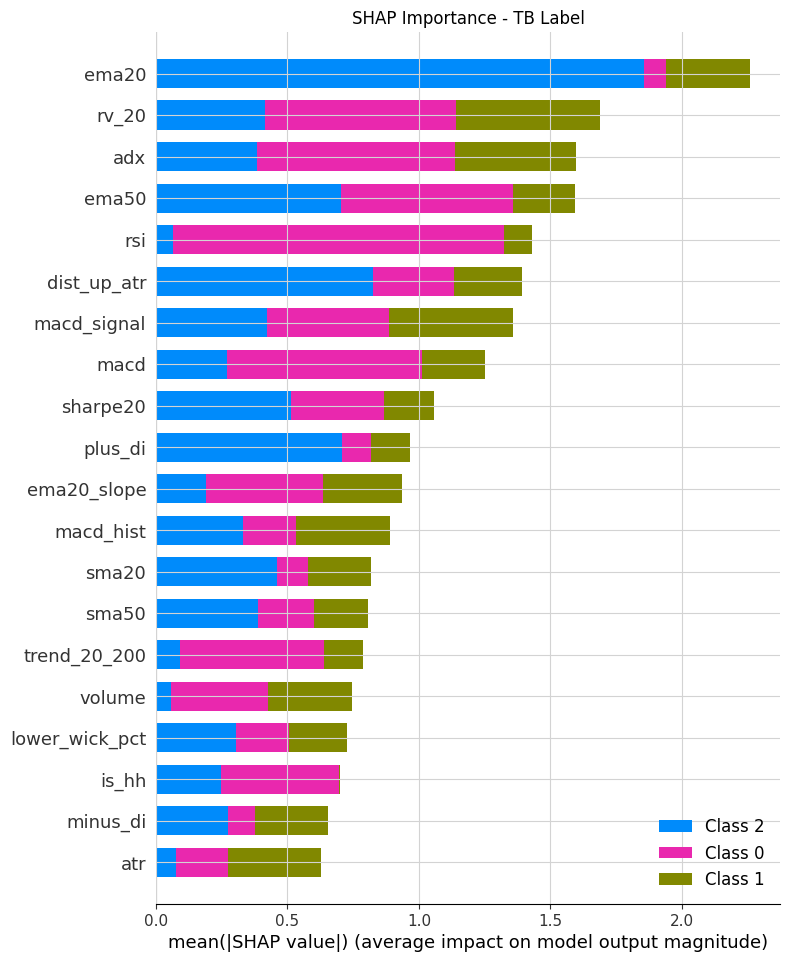

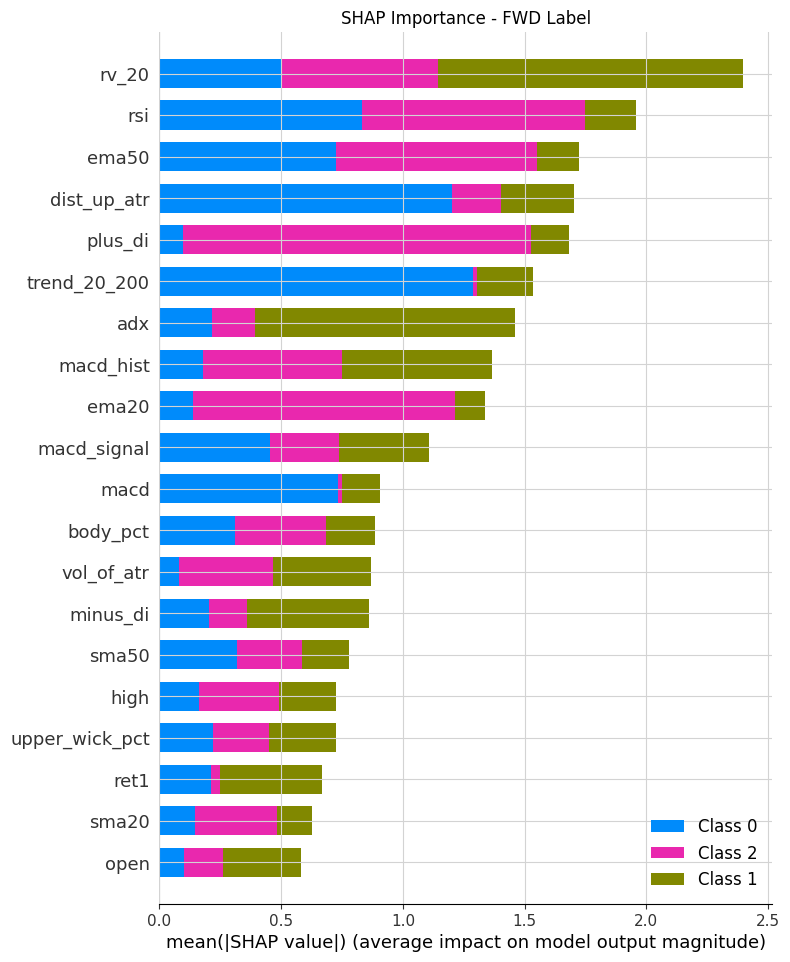

In [81]:
import matplotlib.pyplot as plt
import shap

def show_shap_summary(model, X, title):
    expl = shap.TreeExplainer(model)
    shap_values = expl.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type='bar', show=False)
    plt.title(title)
    plt.show()

show_shap_summary(res_tb['model'], res_tb['X_final'], "SHAP Importance - TB Label")
show_shap_summary(res_fwd['model'], res_fwd['X_final'], "SHAP Importance - FWD Label")


In [82]:
print(y_tb.unique(), y_tb.value_counts())
print(y_fwd.unique(), y_fwd.value_counts())

[ 0.  1. -1.] label_tb_near
 0.0    161
-1.0     50
 1.0     47
Name: count, dtype: int64
[ 0.  1. -1.] label_fwd_near
 0.0    198
-1.0     34
 1.0     26
Name: count, dtype: int64


#📊 วิธีดูจาก SHAP Bar Chart
| สี              | Class   | ความหมาย (ตามกราฟ SHAP)             |
| :-------------- | :------ | :---------------------------------- |
| 🟦 น้ำเงิน      | Class 1 | ขึ้น (take-profit hit → label = +1) |
| 💗 ชมพู         | Class 0 | ลง (stop-loss hit → label = -1)     |
| 🟫 เขียว/น้ำตาล | Class 2 | นิ่ง (timeout → label = 0)          |


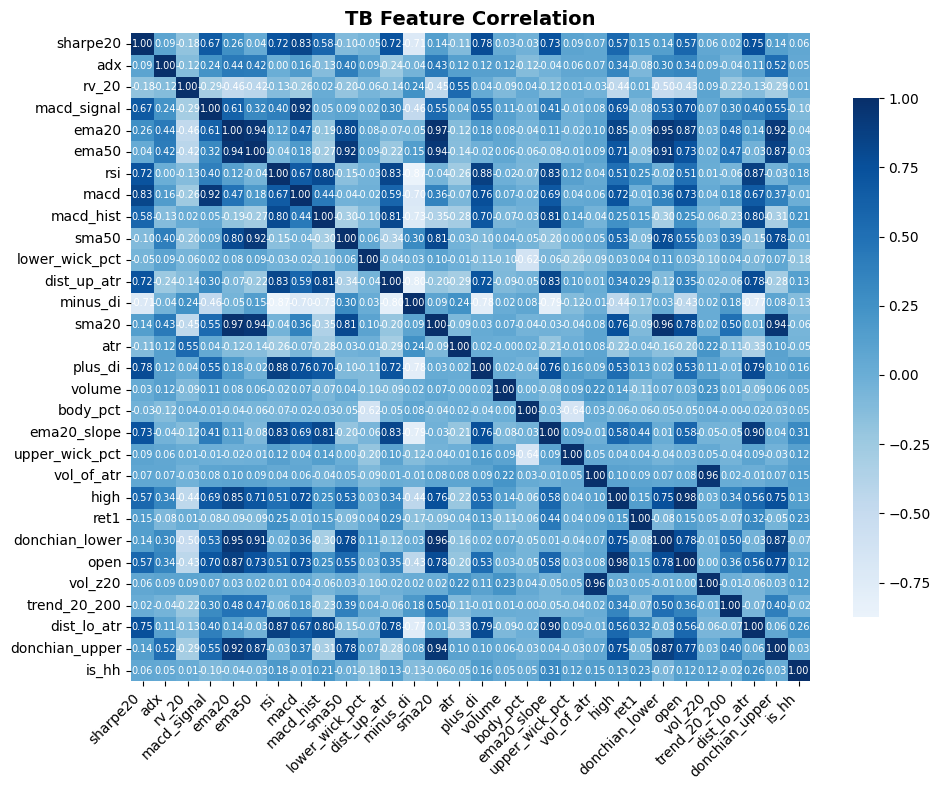

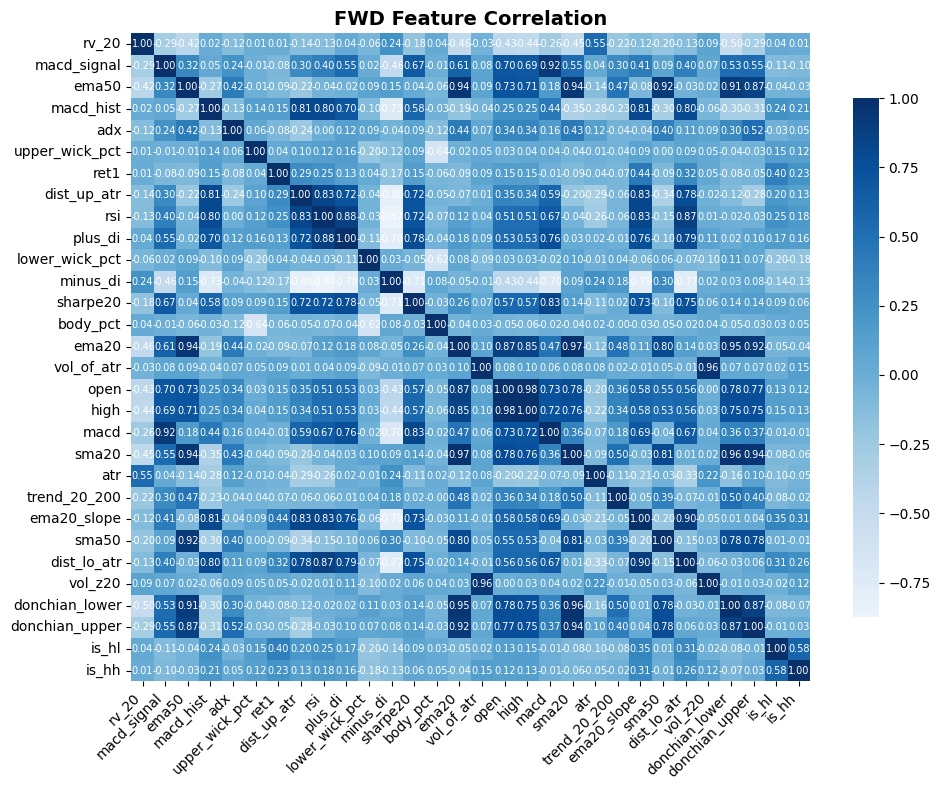

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_corr_matrix(df, title="Correlation Matrix (Clean No Grid)"):
    corr = df.corr()
    plt.figure(figsize=(10, 8))

    ax = sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        center=0,
        annot_kws={"size": 7, "color": "white"},  # ขาวบนพื้นเข้ม
        cbar_kws={"shrink": 0.8},
        square=False,
        linewidths=0,      # ไม่มีเส้น
        linecolor=None,    # ไม่กำหนดสีเส้น
        xticklabels=True,
        yticklabels=True
    )

    # ปิด grid ของ matplotlib ทั้งหมด
    ax.grid(False)
    plt.grid(False)

    # ปิดเส้นรอบ heatmap
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ใช้แบบนี้
plot_corr_matrix(X_tb_final, "TB Feature Correlation")
plot_corr_matrix(X_fwd_final, "FWD Feature Correlation")


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_equity_R(price: pd.Series, signal: pd.Series, fee: float = 0.0002, title: str = "Equity Curve (R)"):
    """
    Plot Equity Curve ของโมเดล
    ------------------------------------
    price  : pd.Series ราคาปิด (index ต้องเป็น datetime)
    signal : pd.Series สัญญาณโมเดล (-1, 0, 1)
    fee    : ค่าธรรมเนียมเทรดต่อการเปลี่ยนสถานะ (default 0.02%)
    title  : ชื่อกราฟ
    """

    # --- เตรียมข้อมูลให้ index ตรงกัน ---
    price = price.sort_index()
    signal = signal.reindex(price.index).fillna(0)

    # --- คำนวณผลตอบแทนต่อแท่ง ---
    ret = price.pct_change().fillna(0)
    trade_cost = np.where(signal.diff().abs() > 0, fee, 0)

    # ผลตอบแทนแต่ละแท่ง (ถือสัญญาณจากแท่งก่อนหน้า)
    strat_ret = (signal.shift(1).fillna(0) * ret) - trade_cost

    # --- Equity curve ---
    equity = strat_ret.cumsum()
    equity_long = ((signal.shift(1) == 1) * ret - trade_cost).cumsum()
    equity_short = ((signal.shift(1) == -1) * -ret - trade_cost).cumsum()

    # --- Metrics ---
    sharpe = np.sqrt(252) * strat_ret.mean() / strat_ret.std() if strat_ret.std() > 0 else 0
    winrate = (strat_ret > 0).mean()
    dd = (equity - equity.cummax()).min()

    avg_gain = strat_ret[strat_ret > 0].mean()
    avg_loss = -strat_ret[strat_ret < 0].mean()
    rrr = avg_gain / avg_loss

    # --- Plot ---
    plt.figure(figsize=(12,6))
    plt.plot(equity, label='Net (Total)', color='tab:blue', linewidth=1.5)
    plt.plot(equity_long, label='Long Only', color='tab:green', linestyle='--')
    plt.plot(equity_short, label='Short Only', color='tab:red', linestyle='--')
    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.title(f"{title}\nSharpe={sharpe:.2f}, Winrate={winrate:.2%}, MaxDD={dd:.2%}, Reward/Risk Ratio={rrr:.2f}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative R")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- สรุปผล ---
    print(f"📈 Final R: {equity.iloc[-1]:.4f}")
    print(f"⚙️ Sharpe: {sharpe:.2f}")
    print(f"✅ Winrate: {winrate:.2%}")
    print(f"💥 Max Drawdown: {dd:.2%}")
    print(f"📈 Reward/Risk Ratio: {rrr:.2f}")


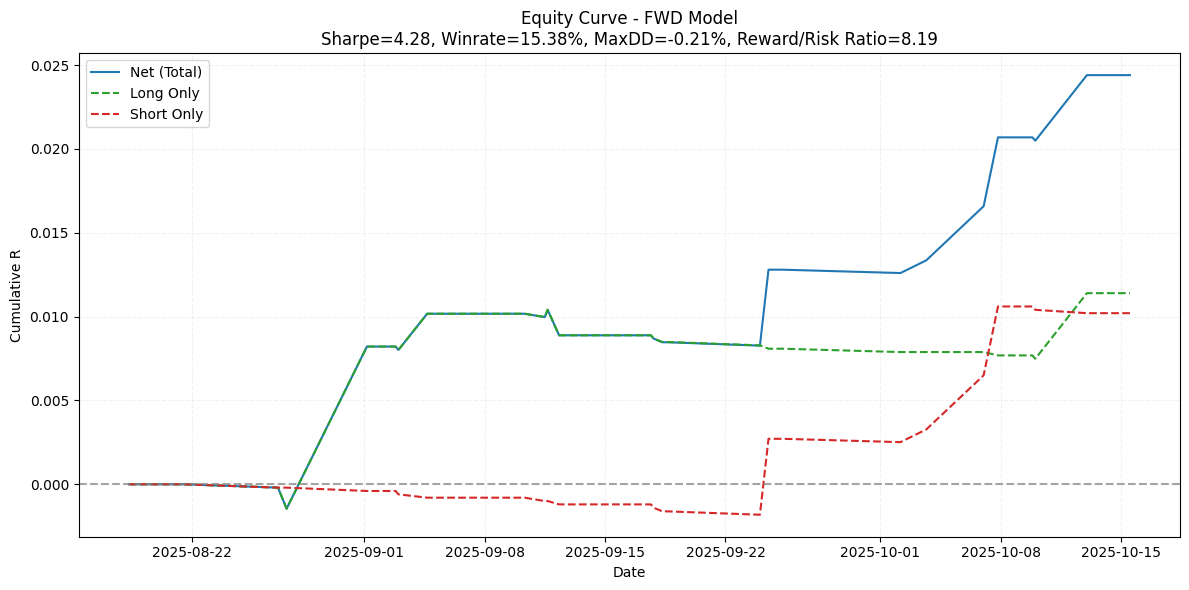

📈 Final R: 0.0244
⚙️ Sharpe: 4.28
✅ Winrate: 15.38%
💥 Max Drawdown: -0.21%
📈 Reward/Risk Ratio: 8.19


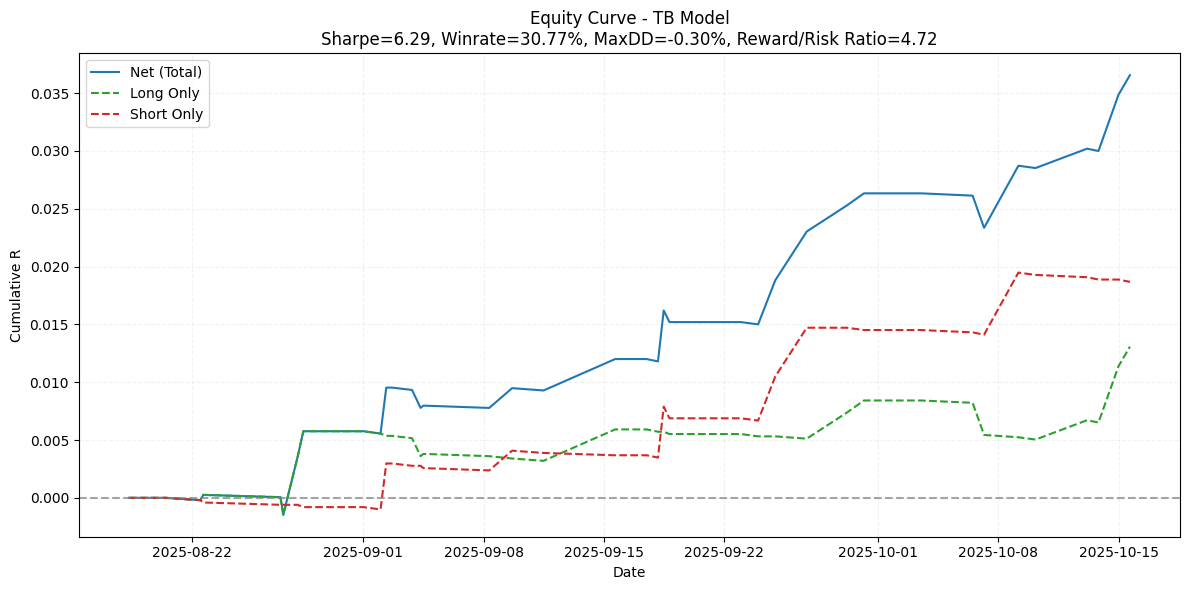

📈 Final R: 0.0366
⚙️ Sharpe: 6.29
✅ Winrate: 30.77%
💥 Max Drawdown: -0.30%
📈 Reward/Risk Ratio: 4.72


In [97]:
# ตัวอย่างกับ FWD model
signal_fwd = pd.Series(y_pred_fwd, index=X_test_fwd.index)
price_fwd = feat.loc[feat.index.isin(signal_fwd.index), 'close']

plot_equity_R(price_fwd, signal_fwd, fee=0.0002, title="Equity Curve - FWD Model")

# ตัวอย่างกับ TB model
signal_tb = pd.Series(y_pred_tb, index=X_test_tb.index)
price_tb = feat.loc[feat.index.isin(signal_tb.index), 'close']

plot_equity_R(price_tb, signal_tb, fee=0.0002, title="Equity Curve - TB Model")


In [98]:
print(f"TB Test Size: {len(X_test_tb)}")
print(f"FWD Test Size: {len(X_test_fwd)}")
print(f"TB Test Date Range: {X_test_tb.index.min()} → {X_test_tb.index.max()}")
print(f"FWD Test Date Range: {X_test_fwd.index.min()} → {X_test_fwd.index.max()}")


TB Test Size: 52
FWD Test Size: 52
TB Test Date Range: 2025-08-18 08:00:00 → 2025-10-15 16:00:00
FWD Test Date Range: 2025-08-18 08:00:00 → 2025-10-15 12:00:00
